In [340]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import re
import shutil
import argparse
import logging
import ast
from StringIO import StringIO

import numpy as np
import pandas as pd
from skimage import io, filters, measure, feature, exposure, color, morphology, draw
from skimage.feature import register_translation
from skimage import transform as tf
import fabio as fb
import mahotas as mh

import scipy.ndimage as ndi

import warnings
warnings.filterwarnings('ignore')

In [79]:
import timeit

_MEASUREMENTS = {
    'Label': 'label',
    'Area': 'area',
    'Perimeter': 'perimeter'
}

_MEASUREMENTS_VALS = _MEASUREMENTS.values()

In [4]:
#https://github.com/zenr/ippy

"""
Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
Usage: $ python max_entropy.py <gray scale image>
"""


def max_entropy(data):
    """
    Implements Kapur-Sahoo-Wong (Maximum Entropy) thresholding method
    Kapur J.N., Sahoo P.K., and Wong A.K.C. (1985) "A New Method for Gray-Level Picture Thresholding Using the Entropy
    of the Histogram", Graphical Models and Image Processing, 29(3): 273-285
    M. Emre Celebi
    06.15.2007
    Ported to ImageJ plugin by G.Landini from E Celebi's fourier_0.8 routines
    2016-04-28: Adapted for Python 2.7 by Robert Metchev from Java source of MaxEntropy() in the Autothresholder plugin
    http://rsb.info.nih.gov/ij/plugins/download/AutoThresholder.java
    :param data: Sequence representing the histogram of the image
    :return threshold: Resulting maximum entropy threshold
    """

    # calculate CDF (cumulative density function)
    cdf = data.astype(np.float).cumsum()

    # find histogram's nonzero area
    valid_idx = np.nonzero(data)[0]
    first_bin = valid_idx[0]
    last_bin = valid_idx[-1]

    # initialize search for maximum
    max_ent, threshold = 0, 0

    for it in range(first_bin, last_bin + 1):
        # Background (dark)
        hist_range = data[:it + 1]
        hist_range = hist_range[hist_range != 0] / cdf[it]  # normalize within selected range & remove all 0 elements
        tot_ent = -np.sum(hist_range * np.log(hist_range))  # background entropy

        # Foreground/Object (bright)
        hist_range = data[it + 1:]
        # normalize within selected range & remove all 0 elements
        hist_range = hist_range[hist_range != 0] / (cdf[last_bin] - cdf[it])
        tot_ent -= np.sum(hist_range * np.log(hist_range))  # accumulate object entropy

        # find max
        if tot_ent > max_ent:
            max_ent, threshold = tot_ent, it

    return threshold

In [162]:
data = io.imread(data_path)
# Contrast stretching
p2 = np.percentile(data, 0.01)
p98 = np.percentile(data, 99.99)
data8bit = exposure.rescale_intensity(data, in_range=(p2, p98), out_range=np.uint8)

In [164]:
hist = np.histogram(data8bit, bins=256, range=(0, 256))[0]

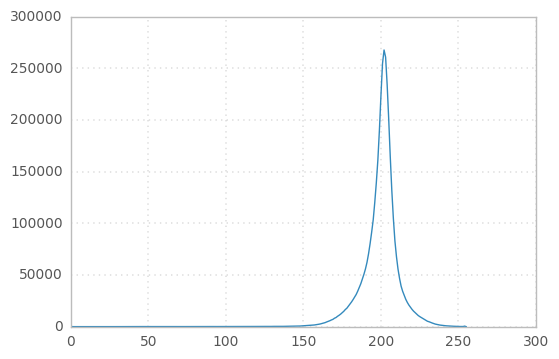

In [165]:
plt.plot(hist)

In [166]:
th = max_entropy(hist)

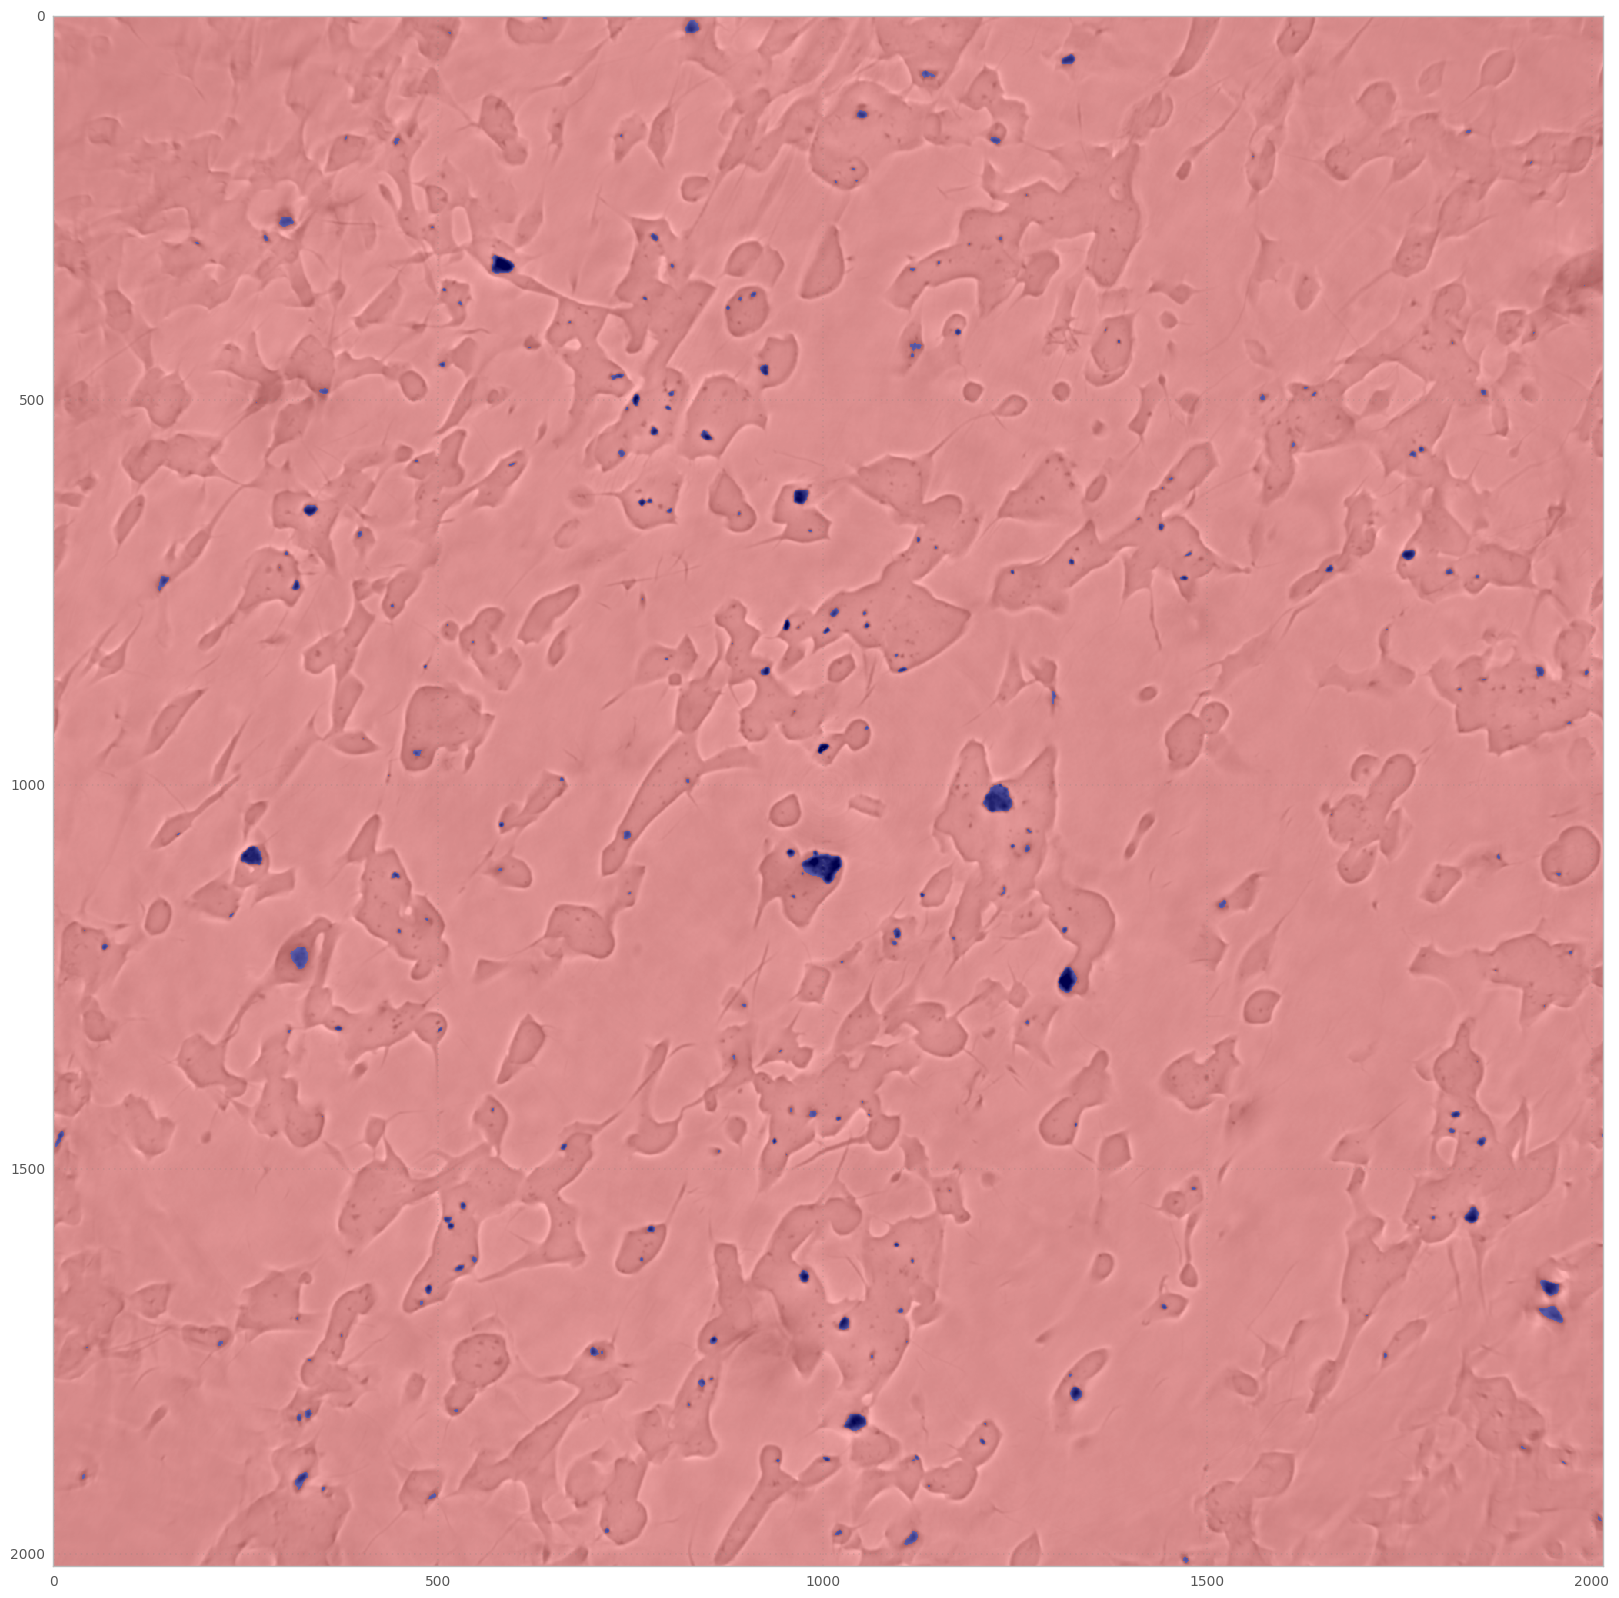

In [167]:
plt.figure(figsize=(20,20))
mask = data8bit <= th
mask = mask.astype(np.uint8)
img = color.gray2rgb(data8bit.astype(np.uint8), alpha=0.2)
plt.imshow(color.label2rgb(mask, image=img))

In [6]:
def tryeval(val):
    try:
        val = ast.literal_eval(val)
    except ValueError:
        pass
    return val

In [7]:
def clear_dir(dir_path):
    filelist = [f for f in os.listdir(dir_path) if f.endswith('.tif')]
    for f in filelist:
        os.remove(os.path.join(dir_path, f))

In [288]:
def write_as_raw(data, sample_name, output_dir, prefix=None):
    bits = -1
    if data.dtype == np.int32 or data.dtype == np.float32:
        bits = 32
    elif data.dtype == np.uint8 or data.dtype == np.bool:
        bits = 8

    size = data.shape[::-1]
    output_filename = '{0}_{1}bit_{2}x{3}x{4}.raw'.format(sample_name, bits, *size) if prefix is None \
                        else '{0}_{1}_{2}bit_{3}x{4}x{5}.raw'.format(sample_name, prefix, bits, *size)
    data.tofile(os.path.join(output_dir, output_filename))

In [8]:
def open_gdocs(url):
    import requests
    r = requests.get(url)
    data = r.content
    df = pd.read_csv(StringIO(data))
    return df

In [319]:
def get_samples_configs(samples_df):
    names = samples_df['Name'].values
    offsets = samples_df['Offsets (start, end)'].values
    bboxes = samples_df['Slice bounding box(x, y, w, h)'].values
    analysis_type = samples_df['Analysis'].values
    structure_type = samples_df['Type'].values
    radii = samples_df['Radius'].values
    
    offsets = [tryeval(v) for v in offsets]
    bboxes = [tryeval(v) for v in bboxes]
    
    return {n: {'offset': o, 'bbox': b, 'analysis_type': a, 'structure': s, 'radius': r} \
                for n, o, b, a, s, r in zip(names, offsets, bboxes, analysis_type, structure_type, radii)}

In [318]:
def get_samples_configs2(samples_df):
    names = samples_df[(samples_df['Priority'] == 'high') & \
                      (samples_df['Reco type'] == 'lamino') & \
                      (samples_df['Camera type'] == 'dimax') & \
                      (samples_df['Analysis'] != 'None')]['Name'].values
    
    offsets = samples_df[(samples_df['Priority'] == 'high') & \
                      (samples_df['Reco type'] == 'lamino') & \
                      (samples_df['Camera type'] == 'dimax') & \
                      (samples_df['Analysis'] != 'None')]['Offsets (start, end)'].values
    
    bboxes = samples_df[(samples_df['Priority'] == 'high') & \
                      (samples_df['Reco type'] == 'lamino') & \
                      (samples_df['Camera type'] == 'dimax') & \
                      (samples_df['Analysis'] != 'None')]['Slice bounding box(x, y, w, h)'].values
    
    analysis_type = samples_df[(samples_df['Priority'] == 'high') & \
                      (samples_df['Reco type'] == 'lamino') & \
                      (samples_df['Camera type'] == 'dimax') & \
                      (samples_df['Analysis'] != 'None')]['Analysis'].values
    
    structure_type = samples_df[(samples_df['Priority'] == 'high') & \
                      (samples_df['Reco type'] == 'lamino') & \
                      (samples_df['Camera type'] == 'dimax') & \
                      (samples_df['Analysis'] != 'None')]['Type'].values
    
    offsets = [tryeval(v) for v in offsets]
    bboxes = [tryeval(v) for v in bboxes]
    
    return {n: {'offset': o, 'bbox': b, 'analysis_type': a, 'structure': s} \
                for n, o, b, a, s in zip(names, offsets, bboxes, analysis_type, structure_type)}

In [257]:
def object_counter(binary_data):
    labeled_stack, num_labels = ndi.measurements.label(binary_data)
    objects_stats = pd.DataFrame(columns=_MEASUREMENTS_VALS)

    labeled_stack_expanded = labeled_stack[np.newaxis,:,:] \
                                if len(labeled_stack.shape) == 2 else labeled_stack

    for labeled_slice in labeled_stack_expanded:
        for region in measure.regionprops(labeled_slice):
            objects_stats = objects_stats.append({_measure: region[_measure] \
                                            for _measure in _MEASUREMENTS_VALS}, \
                                                ignore_index=True)

    objects_stats = objects_stats.groupby('label', as_index=False).sum()

    return objects_stats, labeled_stack

In [136]:
def filter_particles(data, max_area=2000):
    data = data.copy()
    stats, labels = object_counter(data)
    stats = stats[stats['area'] > max_area]
    for index, row in stats.iterrows():
        labels[labels == row['label']] = 0
        
    labels[np.nonzero(labels)] = 1
    
    return labels

In [198]:
def eliminate_structure_holes(mask, max_area=2000):
    data_mask = ndi.morphology.binary_closing(mask, structure=morphology.disk(2), iterations=3)
    
    data_mask_filled = data_mask.copy()
    data_mask_filled = ndi.morphology.binary_fill_holes(data_mask_filled)

    mask_diff = data_mask_filled - data_mask

    data_labeled = filter_particles(mask_diff, max_area=max_area)
    data_labeled = np.logical_or(data_labeled, data_mask).astype(np.uint8)
    
    return data_labeled

In [307]:
def create_mask_with_circle_ROI(data, radius):
    masked_data = mask_data_with_circle(data, radius)
    
    p2 = np.percentile(masked_data, 0.01)
    p98 = np.percentile(masked_data, 99.99)

    data_8bit = exposure.rescale_intensity(masked_data, \
                                           in_range=(p2, p98), \
                                           out_range=np.uint8).astype(np.uint8)
    data_8bit = filters.median(data_8bit, \
                               selem=morphology.disk(5))

    th = mh.otsu(data_8bit, ignore_zeros=True)

    mask = data_8bit >= th
    mask = mask.astype(np.uint8)
    mask = ndi.morphology.binary_fill_holes(mask)
    
    return data_8bit, mask

In [338]:
def mask_data_with_circle(data, radius):
    data_shape = data.shape
    rr,cc = draw.ellipse(data_shape[0]/2, data_shape[1]/2, radius, radius, shape=data_shape)
    circ_mask_roi = np.zeros(data_shape, dtype=np.uint8)
    circ_mask_roi[rr,cc] = 1
    masked_data = data * circ_mask_roi
    
    return masked_data

In [447]:
def segment_sample_with_circle_ROI(samples_configs, \
                                   path_template='./data/hydrogels/{0}/{1}', \
                                   in_folder='reconstructed', \
                                   use_mahotas=False):
    for sample_name, configs in samples_configs.iteritems():
        print 'Sample #' + sample_name
        
        radius = configs['radius']
        atype = configs['analysis_type'].strip()
        struct_type = configs['structure']
        
        components = atype.split('/')
        
        crop_output_dir = path_template.format(sample_name, 'cropped')
        if not os.path.exists(crop_output_dir):
            os.makedirs(crop_output_dir)
        else:
            shutil.rmtree(crop_output_dir)
            os.makedirs(crop_output_dir)

        input_dir = path_template.format(sample_name, in_folder)
        
        print input_dir
        print crop_output_dir
        
        filenames = os.listdir(input_dir)
        filenames = [fn for fn in filenames if fn.endswith('.tif')]
        files = [os.path.join(input_dir, f) for f in filenames]
        
        for i, fpath in enumerate(files):
            data = fb.open(fpath).data
            filename = os.path.basename(fpath)
            
            cropped_data = mask_data_with_circle(data, radius)
            io.imsave(os.path.join(crop_output_dir, filename), cropped_data)
        
        for comp in components:
            output_dir = path_template.format(sample_name, comp.lower() + '_masks')

            if not os.path.exists(output_dir):
                print 'output_dir = ' + output_dir
                os.makedirs(output_dir)
            else:
                print 'output_dir = ' + output_dir
                shutil.rmtree(output_dir)
                os.makedirs(output_dir)

            filenames = os.listdir(crop_output_dir)
            filenames = [fn for fn in filenames if fn.endswith('.tif')]
            files = [os.path.join(crop_output_dir, f) for f in filenames]

            for i, fpath in enumerate(files):
                cropped_data = fb.open(fpath).data
                filename = os.path.basename(fpath)

                if i % 200 == 0 or i == (len(files) - 1):
                    print '%d/%d' % (i, len(files) - 1)
                    
                cropped_data = exposure.rescale_intensity(cropped_data, \
                                                           in_range='image', \
                                                           out_range=(0, 1)).astype(np.float32)
                
                cropped_data = filters.gaussian(cropped_data, sigma=2)
                cropped_data = filters.median(cropped_data, selem=morphology.disk(4))
                
                p2 = np.percentile(cropped_data, 0.01)
                p98 = np.percentile(cropped_data, 99.99)

                data_8bit = exposure.rescale_intensity(cropped_data, \
                                                       in_range=(p2, p98), \
                                                       out_range=np.uint8).astype(np.uint8)
                
                th = mh.otsu(data_8bit, ignore_zeros=True)
                mask = data_8bit >= th
                
                if (np.count_nonzero(mask) / float(cropped_data.shape[0] * \
                                                   cropped_data.shape[1])) > 0.3:
                    hist = np.histogram(data_8bit, bins=256, range=(0, 256))[0]
                    th = max_entropy(hist)
                    mask = data_8bit >= th
                
                mask = mask.astype(np.uint8)
                mask = ndi.morphology.binary_fill_holes(mask).astype(np.uint8)
                
                io.imsave(os.path.join(output_dir, filename), mask)

In [376]:
def segment_sample(samples_configs, \
                   path_template='./data/hydrogels/recon/biomaterials/materials/{0}/tomo1/{1}', \
                   in_folder='slices_phase_particles', \
                   max_area=2500):
    for sample_name, configs in samples_configs.iteritems():
        print 'Sample #' + sample_name
        
        bbox = configs['bbox']
        atype = configs['analysis_type'].strip()
        struct_type = configs['structure']
        
        components = atype.split('/')
        
        data_output_dir = path_template.format(sample_name, 'cropped_data')
        if not os.path.exists(data_output_dir):
            os.makedirs(data_output_dir)
        else:
            shutil.rmtree(data_output_dir)
            os.makedirs(data_output_dir)
            
        input_dir = path_template.format(sample_name, in_folder)
        
        for comp in components:
            output_dir = path_template.format(sample_name, comp.lower() + '_masks')

            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            else:
                shutil.rmtree(output_dir)
                os.makedirs(output_dir)

            filenames = os.listdir(input_dir)
            files = [os.path.join(input_dir, f) for f in filenames]

            working_files = files[configs['offset'][0]: configs['offset'][1]]

            for i, fpath in enumerate(working_files):
                data = io.imread(fpath)

                filename = os.path.basename(fpath)

                if i % 200 == 0 or i == (len(working_files) - 1):
                    print '%d/%d' % (i, len(working_files) - 1)

                data = data[bbox[1]:(bbox[1] + bbox[3] + 1), bbox[0]:(bbox[1] + bbox[2] + 1)]
                p2 = np.percentile(data, 0.01)
                p98 = np.percentile(data, 99.99)
                data8bit = exposure.rescale_intensity(data, in_range=(p2, p98), out_range=np.uint8).astype(np.uint8)
                hist = np.histogram(data8bit, bins=256, range=(0, 256))[0]
            
                if 'particle' in comp.lower():
                    th = max_entropy(hist)
                elif 'polymer' in comp.lower():
                    th = filters.threshold_otsu(data8bit, nbins=256)
                else:
                    raise ValueError('Unknown sample type.')

                mask = data8bit <= th
                mask = mask.astype(np.uint8)
                
                if 'polymer' in comp.lower() and struct_type == 'Thick':
                    mask = eliminate_structure_holes(mask, max_area=max_area)

                io.imsave(os.path.join(output_dir, filename), mask)
                
                cropped_data_path = os.path.join(data_output_dir, filename)
                
                if not os.path.isfile(cropped_data_path):
                    io.imsave(cropped_data_path, data8bit)

In [377]:
def calculate_features(samples_configs, \
                       path_template='./data/hydrogels/recon/biomaterials/materials/{0}/tomo1/{1}'):
    def _create_dir(path):
        if not os.path.exists(path):
            os.makedirs(path)
        else:
            shutil.rmtree(path)
            os.makedirs(path)
        
        return path
    
    for sample_name, configs in samples_configs.iteritems():
        print 'Sample #' + sample_name
        
        atype = configs['analysis_type'].strip()
        components = atype.lower().split('/')
        
        if 'polymer' not in atype.lower() and \
           'particle' not in atype.lower():
                raise ValueError('The sample component(s) are not specified.')
        
        for comp in components: 
            input_dir = path_template.format(sample_name, comp.lower() + '_masks')
            
            filenames = os.listdir(input_dir)
            files = [os.path.join(input_dir, f) for f in filenames]
            try:
                slice_shape = io.imread(files[0]).shape
            except:
                print files[0]
                slice_shape = fb.open(files[0]).data.shape
            
            if 'polymer' in comp.lower():
                print 'Porosity calculation...'
                output_dir = _create_dir(path_template.format(sample_name, 'porosity_stats'))
                
                if not len(files):
                    raise ValueError('No mask files.')

                slice_area = slice_shape[0] * slice_shape[1]
                
                try:
                    porosity_comps = [np.count_nonzero(io.imread(fpath)) / float(slice_area) \
                                      for fpath in files]
                except:
                    porosity_comps = [np.count_nonzero(fb.open(fpath).data) / float(slice_area) \
                                      for fpath in files]

                pd.DataFrame({'Porosity': [sum(porosity_comps)]}, \
                             index=[sample_name]).to_csv(os.path.join(output_dir, \
                                                                      'porosity.csv'))
            if 'particle' in comp.lower():
                print 'Particles counting...'
                output_dir = _create_dir(path_template.format(sample_name, 'particles_stats'))
                
                data_mask_vol = np.zeros((len(files),) + slice_shape, dtype=np.uint8)
                for i,fpath in enumerate(files):
                    try:
                        data_mask_vol[i] = io.imread(fpath)
                    except:
                        data_mask_vol[i] = fb.open(fpath).data
                
                particle_stats, labeled_data = object_counter(data_mask_vol)
                particle_stats.to_csv(os.path.join(output_dir, 'particles.csv'))
                
                write_as_raw(labeled_data, sample_name, output_dir)

In [355]:
calculate_features(dimax_s_configs)

Sample #PCL30
Particles counting...
Porosity calculation...
Sample #PCL21
Porosity calculation...
Sample #PCL26
Particles counting...
Porosity calculation...
Sample #PCL18
Particles counting...
Porosity calculation...
Sample #PCL17
Particles counting...
Porosity calculation...
Sample #PCL16
Particles counting...
Porosity calculation...
Sample #PCL14
Porosity calculation...
Sample #PCL13
Porosity calculation...


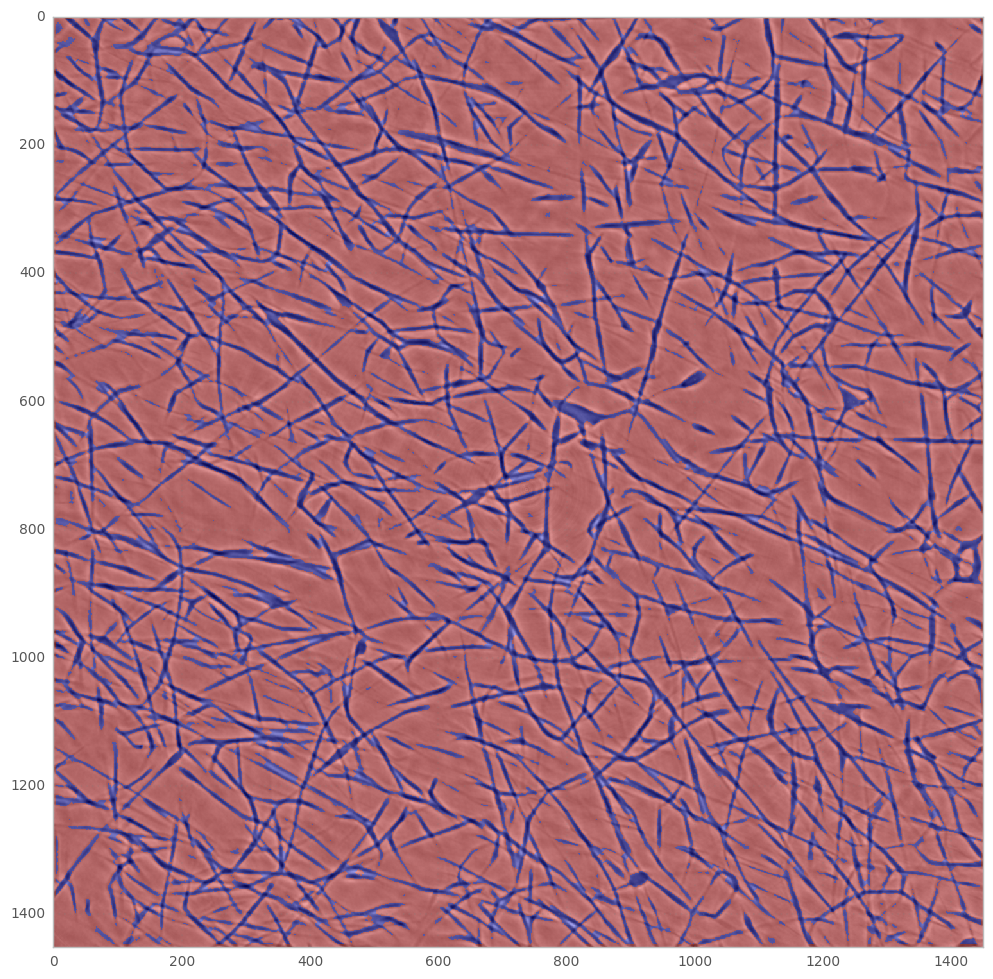

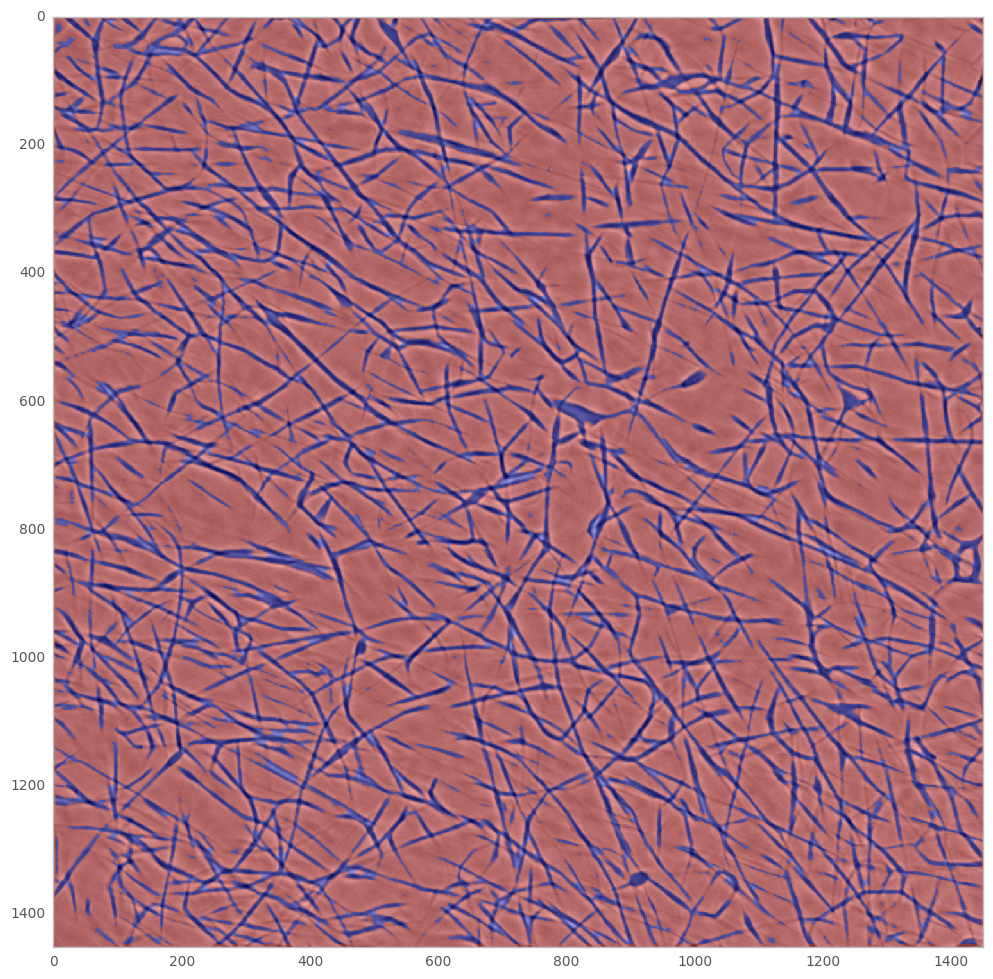

In [178]:
plt.figure(figsize=(12,12))
#plt.imshow(data, cmap='gray')
#plt.imshow(data_mask, cmap='gray')
data = exposure.rescale_intensity(data, in_range='image', out_range=np.uint8)
img = color.gray2rgb(data.astype(np.uint8), alpha=0.9)
plt.imshow(color.label2rgb(data_mask, image=img))

plt.figure(figsize=(12,12))
plt.imshow(color.label2rgb(data_labeled, image=img))

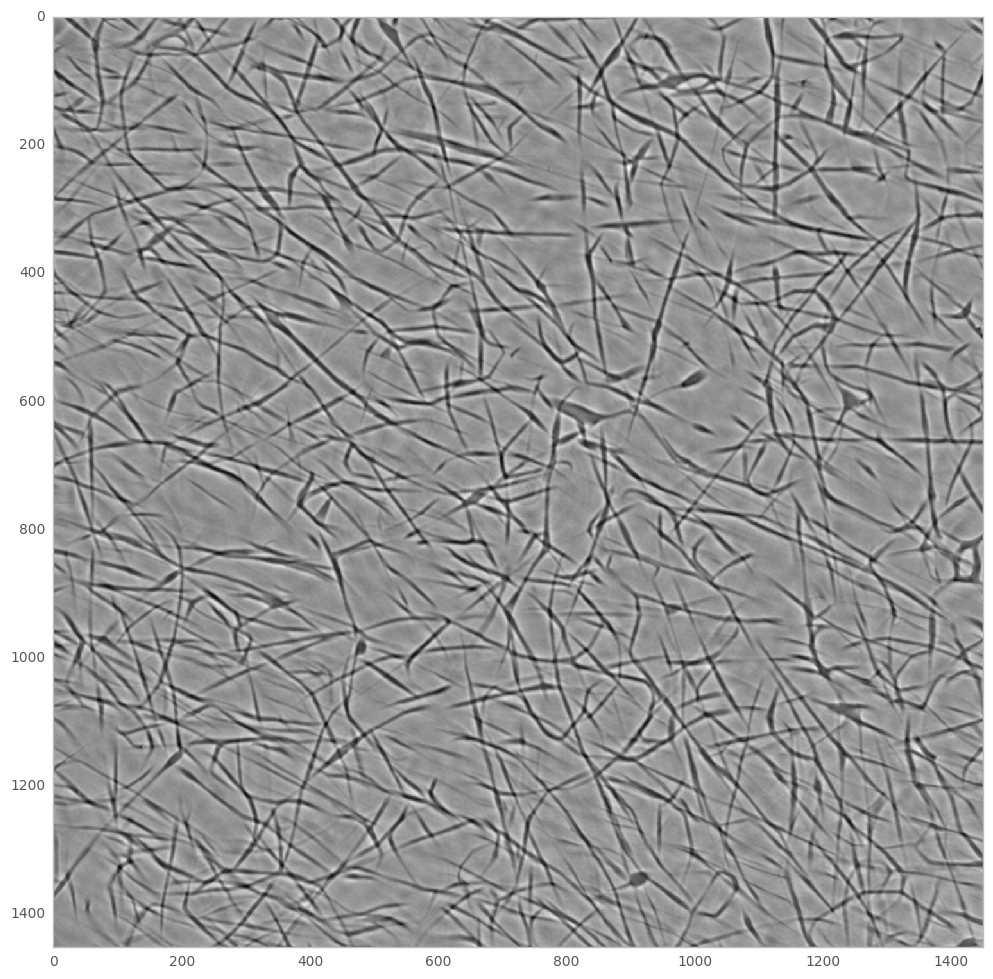

In [179]:
plt.figure(figsize=(12,12))
plt.imshow(data, cmap='gray')